### I’m Something of a Painter Myself

In this week's project, we are participating in Kaggle's competition. We will build a General Adversarial Network Model (GAN) [https://en.wikipedia.org/wiki/Generative_adversarial_network]. We will be using this GAN model to transform photographs to an image that has the painting styles of Monet. 

The dataset comes from Kaggle Competition [https://www.kaggle.com/competitions/gan-getting-started]. The dataset consists the following:
1. 300 Monet painting 8-bit RGB iamges, with dimensions of 256x256 pixels.
2. 7038 photograph 8-bit RGB images, with dimensions of 256x256 pixels.
3. TFRecord dataset of the above two datasets.

The goal of this project is to Build a Generator to transform photos to Monet style paintings (and vice versa), and Discrimnator to differentiate real Monet painting images to generated Monet style painting images (or differentiate real photographs from generated photograhs).

Github Repository: https://github.com/dfu2020/DTSA-5511/tree/main/Week5

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets

print(tf.__version__)
tfds.disable_progress_bar()
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
autotune = tf.data.AUTOTUNE


2024-04-29 21:58:32.708683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 21:58:32.708782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 21:58:32.837752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
Number of replicas: 1


In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
# Definition of several helper functions to decode image,
# read and laod the tfrec data format.
# Source: Jang, A., Monet CycleGAN Tutorial.
# https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

IMAGE_SIZE = [256, 256]
# function to decode the image from jpeg.
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# function to read the tfrec file format
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# function to load the tfrec files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

In [8]:
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(8, int(8*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()

Monet painting samples


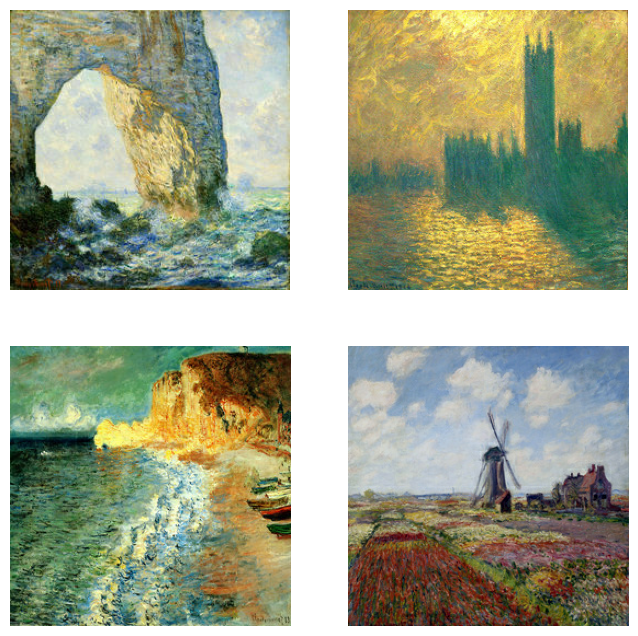

In [9]:
print('Monet painting samples')
display_samples(monet_ds,2,2)

Photo samples


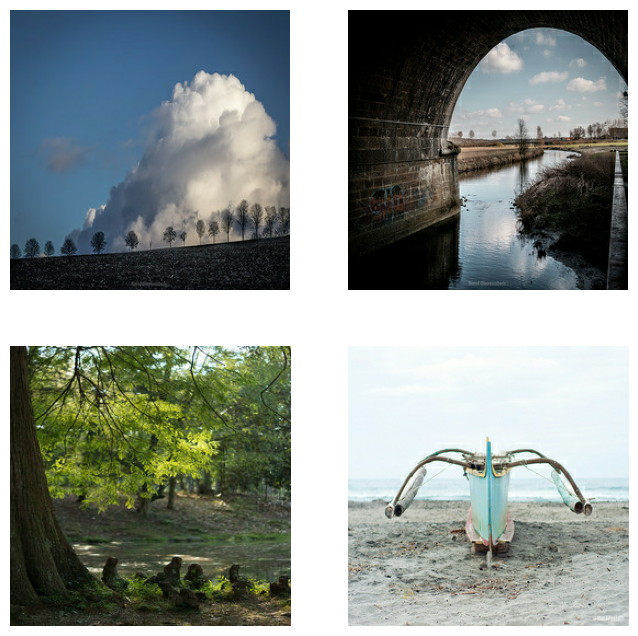

In [10]:
print('Photo samples')
display_samples(photo_ds,2,2)

### Build the Generator

In [11]:
# The following functions come from:
# Source: Jang, A., Monet CycleGAN Tutorial.
# https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.UpSampling2D())
    result.add(layers.Conv2D(filters, size, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    
    return result

In [12]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Define encoder layers
    encoder_layers = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    # Define decoder layers
    decoder_layers = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the encoder
    skips = []
    for down in encoder_layers:
        x = down(x)
        skips.append(x)

    skips = list(reversed(skips[:-1]))

    # Upsampling and establishing the skip connections
    for up, skip in zip(decoder_layers, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Build the Discriminator

In [13]:
def Discriminator():
    
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inputs

    # Downsampling layers
    x = downsample(64, 4, apply_batchnorm=False)(x)  # (bs, 128, 128, 64)
    x = downsample(128, 4)(x)  # (bs, 64, 64, 128)
    x = downsample(256, 4)(x)  # (bs, 32, 32, 256)

    # Convolutional layer
    x = layers.Conv2D(512, 4, strides=1, padding='valid',
                    kernel_initializer=tf.random_normal_initializer(0., 0.02),
                    use_bias=False)(x)  # (bs, 29, 29, 512)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Output layer
    output = layers.Conv2D(1, 4, strides=1, padding='valid',
                        kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)  # (bs, 26, 26, 1)

    return keras.Model(inputs=inputs, outputs=output)

In [14]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


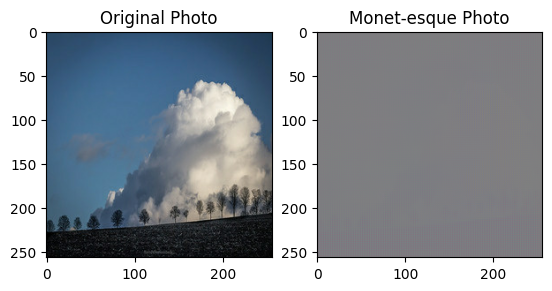

In [15]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### Build the CycleGAN model

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Forward pass through generators
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # Forward pass through discriminators
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # Generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # Cycle consistency losses
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                            self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            # Identity losses
            total_monet_identity_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_identity_loss = self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # Total generator losses
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + total_monet_identity_loss
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + total_photo_identity_loss
            
            # Discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        
        # Generator gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        
        # Discriminator gradients
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        
        # Apply gradients to optimizers
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Define loss functions

In [17]:
with strategy.scope():
    def discriminator_loss(real, generated):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        real_loss = bce(tf.ones_like(real), real)
        generated_loss = bce(tf.zeros_like(generated), generated)
        total_disc_loss = tf.reduce_mean(real_loss + generated_loss) * 0.5
        return total_disc_loss
    
    def generator_loss(generated):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        return tf.reduce_mean(bce(tf.ones_like(generated), generated))
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    def identity_loss(real_image, same_image, LAMBDA):
        return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

### Train the CycleGAN Model

In [18]:
# Define the learning rate and beta_1 for the optimizers
learning_rate = 2e-5
beta_1 = 0.5

# Create optimizers for generators and discriminators
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)


In [19]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [20]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20


I0000 00:00:1714428038.447128      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 170s 219ms/step - monet_disc_loss: 0.6760 - monet_gen_loss: 8.5421 - photo_disc_loss: 0.6582 - photo_gen_loss: 8.7446 - loss: 0.0000e+00
Epoch 2/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - monet_disc_loss: 0.6330 - monet_gen_loss: 6.2940 - photo_disc_loss: 0.6345 - photo_gen_loss: 6.3481 - loss: 0.0000e+00
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 5.4931 - photo_disc_loss: 0.6203 - photo_gen_loss: 5.5065 - loss: 0.0000e+00
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 5.1356 - photo_disc_loss: 0.6150 - photo_gen_loss: 5.1159 - loss: 0.0000e+00
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - monet_disc_loss: 0.5875 - monet_gen_loss: 4.9152 - photo_disc_loss: 0.6168 - photo_gen_loss: 4.8461 - loss: 0.0000e+00
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 219ms/step - monet_disc_loss: 0.5677 - monet_gen_loss: 4.7891 - photo_disc_loss: 0.6115 - photo_gen_loss: 4.6666 - loss: 0.0000e+00
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - monet_disc_loss: 0.5445 - monet_gen_loss: 4.7242 - photo_disc_loss: 0.5992

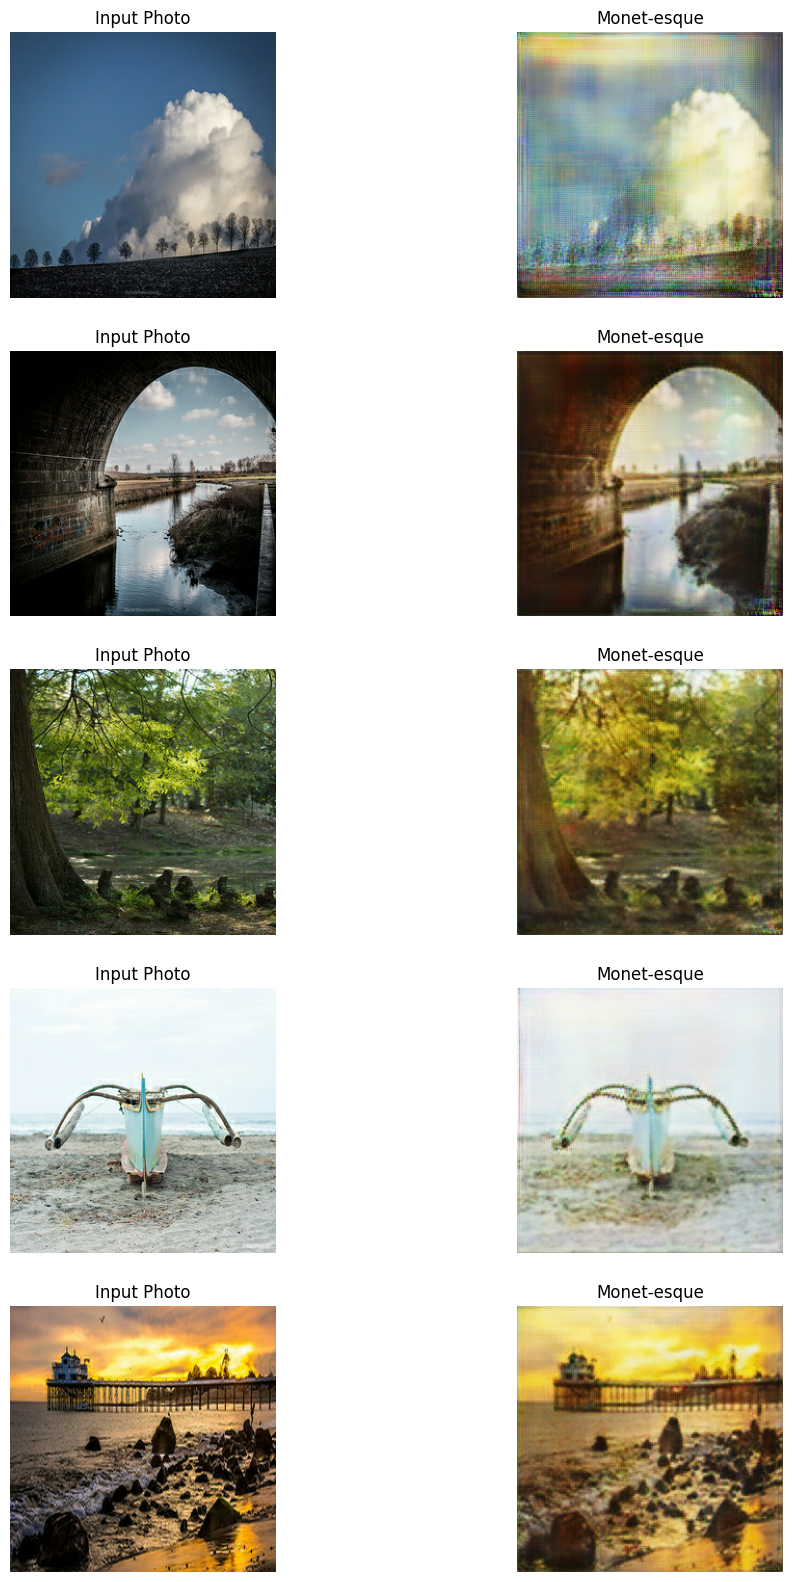

In [21]:
fig, ax = plt.subplots(5, 2, figsize=(12, 20))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [22]:
import PIL
! mkdir ../images
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")


'/kaggle/working/images.zip'

### Summary
This project is quite time consuming. Following the Kaggle Monet CycleGAN tutorial, I was able to generate Monet style images from the real photograph images. While I received a cometition score of 76.37 on the Kaggle Leaderboard.

I noticed that by tweeking the learning rate from 2e-4 to 2e-5, it resulted in a higher score in Kaggle's MiFID (Memorization-informed FID) score, and the generated Monet style photograph images looked more "blurry" (in some sense, look more like Monet's Painting). However, when examining the generated submission images, I also noticed that depending on the content and contrast of the photograph image, the "Monet" style filter may be more prominent. When the learning rate was 2e-4, some of the generated Monet style photograph images have little noticeable different (apart from being slightly coarser resolution).

Also I want to mention the use of enhanced GPU / TPU resources on Kaggle, which helped to improve the processing time of the notebook. At first I was running this jupyter notebook on my laptop, and the runtime lasted ~ 2 hours. It was when I tried to submit my local zip archive to Kaggle that I realized that Kaggle doesn't accept a submission without a linked online notebook. Thus I reformatted my notebook to work on Kaggle's server. This also allowed me to utilize the enhanced GPU on Kaggle's server, and shortened the run time to under 30 mins.

While completing this project, I found several useful resources that helped with the understanding of the model setup and the formed the basis of my code structure.
Jang, A., Monet CycleGAN Tutorial.[https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial]

Keras CycleGAN tutorial example. [https://keras.io/examples/generative/cyclegan/]